![image.png](https://i.imgur.com/a3uAqnb.png)

# **🚀 Exercise: Build a Smoking Detection Classifier**
In this exercise, you will **train a binary classifier** to detect whether a person is **smoking** or **not smoking** using the `Smoking` dataset.

✅ **You will:**

1️⃣ Download the dataset.  
2️⃣ Build a **custom Dataset class** to handle image loading.  
3️⃣ Use **ResNet-18** as a pretrained model (can be accessed via: from torchvision.models import resnet18).  
4️⃣ Train the model and report **Training, Validation, and Testing Accuracy**.  
5️⃣ Display some **predictions along with images** at the end.  

In [1]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("sujaykapadnis/smoking")

print("Path to dataset files:", path)

100%|██████████| 63.8M/63.8M [00:06<00:00, 10.7MB/s]

Extracting files...


Path to dataset files: C:\Users\trh00\.cache\kagglehub\datasets\sujaykapadnis\smoking\versions\5


In [9]:
import os

# List files in the training dataset
root_dir_training = r'C:\Users\trh00\.cache\kagglehub\datasets\sujaykapadnis\smoking\versions\5\Training\Training'
root_dir_validation = r'C:\Users\trh00\.cache\kagglehub\datasets\sujaykapadnis\smoking\versions\5\Validation\Validation'
root_dir_testing = r'C:\Users\trh00\.cache\kagglehub\datasets\sujaykapadnis\smoking\versions\5\Testing\Testing'

training_files = os.listdir(root_dir_training)
validation_files = os.listdir(root_dir_validation)
testing_files = os.listdir(root_dir_testing)
print(validation_files[:3])

['notsmoking_0006.jpg', 'notsmoking_0017.jpg', 'notsmoking_0024.jpg']


In [10]:
print("Number of training files:", len(training_files))

Number of training files: 716


In [11]:
from torch.utils.data import Dataset
from torchvision import transforms
from PIL import Image
import torch
from torch.utils.data import DataLoader

class SmokingDataset(Dataset):
    def __init__(self, root_dir, img_paths, transform=None):
        self.root_dir = root_dir
        self.img_paths = img_paths
        if transform:
            self.transform = transform
    def __len__(self):
        return len(self.img_paths)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.img_paths[idx])
        if 'notsmoking' in img_path:
            label = 0
        else:
            label = 1
        image = Image.open(img_path)
        image = self.transform(image)

        label = torch.tensor(label, dtype=torch.long)
        return image, label

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

train_dataset = SmokingDataset(root_dir_training, training_files, transform=transform)
val_dataset = SmokingDataset(root_dir_validation, validation_files, transform=transform)
test_dataset = SmokingDataset(root_dir_testing, testing_files, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=True)


In [31]:
from torchvision.models import resnet18
import torch.nn as nn
model = resnet18(weights=True)
model.fc = nn.Linear(512, 2)
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

In [32]:
from tqdm import tqdm    # Shows progress bar

# 🔹 Training Loop
def train_one_epoch(model, dataloader, criterion, optimizer, device):
    model.train()  # Set model to training mode
    total_loss = 0
    correct = 0
    total = 0

    for images, labels in tqdm(dataloader):
        images, labels = images.to(device), labels.to(device)

        
        outputs = model(images)  # Forward pass
        # print(outputs)
        # print(labels)
        loss = criterion(outputs, labels)  # Compute loss

        optimizer.zero_grad()  # Reset gradients
        loss.backward()  # Backpropagation
        optimizer.step()  # Update weights

        total_loss += loss.item()

        # Track accuracy
        outputs = torch.softmax(outputs, dim=1)
        predictions = outputs.argmax(dim=1)  # Get class with highest probability
        correct += (predictions == labels).sum().item()
        total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy

# 🔹 Validation Loop
def validate(model, dataloader, criterion, device):
    model.eval()  # Set model to evaluation mode
    total_loss = 0
    correct = 0
    total = 0

    with torch.no_grad():  # Disable gradient computation
        for images, labels in dataloader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)  # Forward pass
            loss = criterion(outputs, labels)  # Compute loss
            total_loss += loss.item()

            # Compute accuracy
            outputs = torch.softmax(outputs, dim=1)
            predictions = outputs.argmax(dim=1)  # Get predicted class
            correct += (predictions == labels).sum().item()
            total += labels.size(0)

    avg_loss = total_loss / len(dataloader)
    accuracy = 100 * correct / total  # Compute accuracy in percentage
    return avg_loss, accuracy


In [33]:
import torch.optim as optim

# Initialize the model
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # Cross-entropy loss  
optimizer = optim.Adam(model.parameters(), lr=0.001)  # Adam optimizer
num_epochs = 10 # Number of epochs


# Lists to store metrics
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []

# Training process
for epoch in range(num_epochs):
    train_loss, train_accuracy = train_one_epoch(model, train_loader, criterion, optimizer, device)
    val_loss, val_accuracy = validate(model, test_loader, criterion, device)

    # Store metrics
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accuracies.append(train_accuracy)
    val_accuracies.append(val_accuracy)

    print(f"Epoch {epoch+1}/{num_epochs}: "
          f"Train Loss={train_loss:.4f}, Train Accuracy={train_accuracy:.2f}%, "
          f"Val Loss={val_loss:.4f}, Val Accuracy={val_accuracy:.2f}%")


100%|██████████| 23/23 [00:14<00:00,  1.58it/s]


Epoch 1/10: Train Loss=0.7211, Train Accuracy=74.02%, Val Loss=0.8536, Val Accuracy=66.96%


100%|██████████| 23/23 [00:14<00:00,  1.54it/s]


Epoch 2/10: Train Loss=0.4370, Train Accuracy=79.47%, Val Loss=0.4770, Val Accuracy=83.04%


100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Epoch 3/10: Train Loss=0.2573, Train Accuracy=88.69%, Val Loss=0.4018, Val Accuracy=83.93%


100%|██████████| 23/23 [00:14<00:00,  1.56it/s]


Epoch 4/10: Train Loss=0.1503, Train Accuracy=94.69%, Val Loss=0.7093, Val Accuracy=78.57%


100%|██████████| 23/23 [00:13<00:00,  1.68it/s]


Epoch 5/10: Train Loss=0.1987, Train Accuracy=92.46%, Val Loss=0.4618, Val Accuracy=82.59%


100%|██████████| 23/23 [00:13<00:00,  1.73it/s]


Epoch 6/10: Train Loss=0.1563, Train Accuracy=94.41%, Val Loss=0.7227, Val Accuracy=80.36%


100%|██████████| 23/23 [00:13<00:00,  1.65it/s]


Epoch 7/10: Train Loss=0.1243, Train Accuracy=95.53%, Val Loss=0.5912, Val Accuracy=80.36%


100%|██████████| 23/23 [00:13<00:00,  1.69it/s]


Epoch 8/10: Train Loss=0.0518, Train Accuracy=98.46%, Val Loss=0.6091, Val Accuracy=84.38%


100%|██████████| 23/23 [00:13<00:00,  1.71it/s]


Epoch 9/10: Train Loss=0.0392, Train Accuracy=98.46%, Val Loss=1.0034, Val Accuracy=77.23%


100%|██████████| 23/23 [00:17<00:00,  1.33it/s]


Epoch 10/10: Train Loss=0.0631, Train Accuracy=97.91%, Val Loss=0.5687, Val Accuracy=82.59%


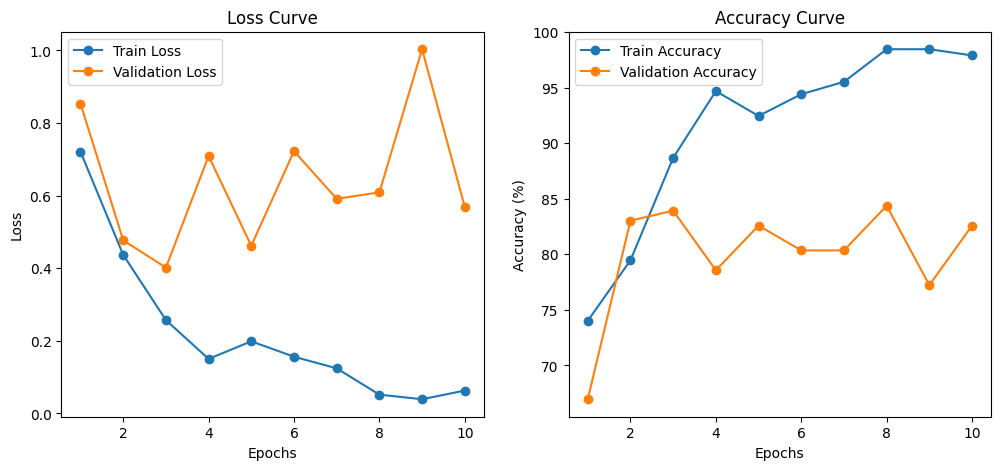

In [34]:
import matplotlib.pyplot as plt

# Plot loss curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(range(1, num_epochs+1), train_losses, label="Train Loss", marker='o')
plt.plot(range(1, num_epochs+1), val_losses, label="Validation Loss", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Loss Curve")
plt.legend()

# Plot accuracy curve
plt.subplot(1, 2, 2)
plt.plot(range(1, num_epochs+1), train_accuracies, label="Train Accuracy", marker='o')
plt.plot(range(1, num_epochs+1), val_accuracies, label="Validation Accuracy", marker='o')
plt.xlabel("Epochs")
plt.ylabel("Accuracy (%)")
plt.title("Accuracy Curve")
plt.legend()

plt.show()
